In [ ]:
%pip install pandas==1.5.1
%pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 4.7 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 830 kB 4.9 MB/s 
     |████████████████████████████████| 280 kB 60.8 MB/s 
     |████████████████████████████████| 1.6 MB 89.2 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16321 sha256=9b64c31f2dae2495490dc15c86466b9186e1b766fe5d8d593c0bfbba35817db3
  Stored in directory: /root/.cache/pip/wheels/08/66/b4/921e351e63d88696932279d6163e125727c9da70ed8ca38419
Succ

In [ ]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
import swifter
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from matplotlib import image as mpimg
import re
from PIL import Image
from itertools import chain
import glob
import os
import pandas as pd
from torchmetrics import TweedieDevianceScore
sns.set_style('whitegrid')

In [ ]:
#Checking the GPU info on colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 15 14:31:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Helpful functions 

In [ ]:
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error as MSE

#Computing poisson deviance (need to make sure that the predicition is positive before hand)
def custom_poisson_deviance(y_true,y_pred):
  prediction=y_pred.copy()
  prediction[np.where(prediction<=0)]=10**(-10)
  return mean_poisson_deviance(y_true,prediction)


#function that tries to open the image, return 1 if fails 0 else 
def check_corrupted(Path):
  try: 
    Image.open(Path)
    return 0
  except:
    return 1

#Function to get the size of an image given the filepath
def get_size(path):
  image=Image.open(path)
  return np.array(image).shape

#Function to check if an image is RGB
def RGB(dimension):
  try: 
    return dimension[2]==3
  except:
    return False



In [ ]:
#On colab I had trouble importing the random split function of the torch library so I imported it here manually
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset


def random_split(dataset, lengths,
                 generator=default_generator):
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-t/ype]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

# Setting up data

In [ ]:
#checking if gpu is available (for google colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# when using this this notebook on colab, the most efficient way to access the data is to have them store on your drive (You might have to upgrade your drive to get more storage)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#The path of the data: (as I am using drive, colab access it via the path /content/drive/MyDrive/)
PATH='/content/drive/MyDrive/Data/'
#The image folder in the path (here I stored my images in '/content/drive/MyDrive/Data/Images/'), 
#To import the images on drive, I have imported the zipfil on drive and unzipped it in the section 'Creating dataset with filenames, id and preprocessing', 
#giving me a folder 'Images' containing the zipfile content in the path
IMAGE_FOLDER='Images/'

In [ ]:
with open(PATH+"listings.pkl", "rb") as fh:
    data = pickle.load(fh)
with open(PATH+"test_listings_image.pkl", "rb") as fh:
    data_test = pickle.load(fh)
with open(PATH+"test_listings_overall.pkl", "rb") as fh:
    data_test_overall = pickle.load(fh)

In [ ]:
#Checking that the ids in test images and test overall are the same
(data_test.sort_values(by='Property Reference Id')['Property Reference Id'].values==data_test_overall.sort_values(by='Property Reference Id')['Property Reference Id'].values).sum()

10000

In [ ]:
tabular_data_train=data.drop('Demand',axis=1)
label_train=data['Demand']

In [ ]:
tabular_data_pred=data_test_overall.drop('Prediction',axis=1)
label_pred=data_test_overall['Prediction']

# Setting up tabular data

In [ ]:
from sklearn.preprocessing import FunctionTransformer

In [ ]:
#Initialising a random seed for reproducibility
seed=np.random.randint(100)
#Creating dictionaries to encode categories into integers
DICT_GEO_CANTON={'ZH':0, 'VD':1, 'BE':2, 'AG':3, 'FR':4, 'SG':5, 'LU':6, 'SO':7, 'SH':8, 'GE':9, 'VS':10,
       'SZ':11, 'BS':12, 'ZG':13, 'BL':14, 'NE':15, 'TI':16, 'GR':17, 'TG':18, 'AR':19, 'UR':20, 'GL':21,
       'NW':22, 'JU':22}
DICT_SUBCATEGORY={'Apartment':0, 'Duplex':1, 'Row house':2, 'Roof flat':3, 'Attic flat':4,
       'Single house':5, 'Single Room':6, 'Studio':7, 'Furnished dwelling':8,
       'Loft':9, 'Mansard':10, 'Farm house':11}
DICT_CATEGORY_IDX={'APPT':0,'HOUSE':1}
geo_values=data['Geo City'].unique()
DICT_GEO_CITY= {geo_values[i]: [x for x in range(0,len(geo_values))][i] for i in range(len(geo_values))}
geo_zip_val=data['Geo Zip'].unique()
DICT_GEO_ZIP= {geo_zip_val[i]: [x for x in range(0,len(geo_zip_val))][i] for i in range(len(geo_zip_val))}

In [ ]:
#identifying the boolean variables
bool_features=['Are Pets Allowed', 'Has Balcony', 'Has Cabletv',
               'Has Elevator', 'Has Fireplace', 'Has Garage',
               'Has Parking', 'Is New Construction', 'Is New Construction Potential', 
               'Is Tenant2Tenant', 'Is Wheelchairaccessible']
print(bool_features)

['Are Pets Allowed', 'Has Balcony', 'Has Cabletv', 'Has Elevator', 'Has Fireplace', 'Has Garage', 'Has Parking', 'Is New Construction', 'Is New Construction Potential', 'Is Tenant2Tenant', 'Is Wheelchairaccessible']


In [ ]:
other_categorical_features=['Category Idx','Geo City','Geo Zip']

#The ordinal features are:
ordinal_features=['Floor','Jahr', 'Leerwohnungsziffer','Livingspace', 'Number Of Rooms',
       'Number Of Rooms Cleaned', 'Number of Documents', 'Number of Images',
       'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 
       'Size M2 Normalized', 'Year Built',
       'Year Lastrenovated',]
#ordinal_features+=['Len Description']


In [ ]:
#Extract numerical features from 'Day of Advertisement Created', 'Day of Date Available From', 'Listing Description' and 'Listing Title'
def len_string(x):
  try:
    return len(x)
  except:
    return 0
def adding_features(X: pd.DataFrame, y=None):
    X_copy=X.copy()
    threshold=datetime.datetime(2022,9,1)
    X_copy['Days Between September and Created']=pd.to_datetime(X_copy['Day of Advertisement Created']).apply(lambda x:(threshold-x).days)
    X_copy['Days Between September and Available']=pd.to_datetime(X_copy['Day of Date Available From']).apply(lambda x:(threshold-x).days)                                                           
    X_copy.drop(['Day of Advertisement Created','Day of Date Available From'],axis=1,inplace=True)

    X_copy['Len Listing Description']=X_copy['Listing Description'].apply(lambda x:len_string(x))
    X_copy['Len Listing Title']=X_copy['Listing Title'].apply(lambda x:len_string(x))                                                           
    X_copy.drop(['Listing Description','Listing Title'],axis=1,inplace=True)
    
    #X_copy['Len Description']=X_copy['Listing Description'].apply(lambda x:len_text(x))
    X_copy=X_copy.drop(['Geo City'],axis=1)
    X_copy['Leerwohnungsziffer']=X_copy['Leerwohnungsziffer'].astype('float')
                
    return X_copy

adding_features_transformer = FunctionTransformer(adding_features)

print('Transforming features')
display(adding_features_transformer.transform(tabular_data_train))

Transforming features


,Are Pets Allowed,Category Idx,Floor,Geo Canton,Geo Zip,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,Has Garage,...,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Days Between September and Created,Days Between September and Available,Len Listing Description,Len Listing Title
0,NaN,APPT,0.0,ZH,8600,NaN,NaN,NaN,NaN,NaN,...,3910.0,0002.03.7648,232.0,Apartment,2016.0,2016.0,602,549.0,2122,41
1,NaN,APPT,1.0,VD,1052,NaN,NaN,NaN,NaN,NaN,...,1225.0,9680.61.2071,45.0,Apartment,NaN,NaN,1018,914.0,610,16
2,False,APPT,1.0,BE,4900,False,False,False,False,False,...,1320.0,7204.61.8658,103.0,Apartment,NaN,NaN,1996,NaN,741,39
3,True,APPT,1.0,AG,5442,NaN,True,NaN,NaN,True,...,1210.0,7410.50.5987,86.0,Apartment,1985.0,1985.0,421,488.0,1381,53
4,False,APPT,0.0,FR,1630,False,False,False,False,False,...,1190.0,9270.61.7822,79.0,Apartment,NaN,NaN,1763,1857.0,653,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,APPT,2.0,SG,9000,False,False,False,False,False,...,1180.0,4458.50.0065,90.0,Apartment,NaN,NaN,1701,1614.0,558,18
19996,True,APPT,2.0,VD,1800,NaN,True,True,NaN,True,...,1750.0,4481.61.5904,84.0,Apartment,1968.0,1968.0,302,212.0,646,20
19997,NaN,APPT,5.0,GE,1212,NaN,NaN,NaN,NaN,NaN,...,1900.0,0221.61.7685,68.0,Apartment,NaN,NaN,321,442.0,526,64
19998,NaN,APPT,7.0,VD,1260,NaN,NaN,NaN,NaN,NaN,...,3300.0,8508.50.4399,95.0,Apartment,NaN,NaN,700,488.0,479,29


In [ ]:
categorical_features={'Category Idx':DICT_CATEGORY_IDX,'Geo Zip':DICT_GEO_ZIP,'Geo Canton':DICT_GEO_CANTON,'Subcategory En Idx':DICT_SUBCATEGORY}
#DEALING WITH NAN
def fill_nan(X: pd.DataFrame,bool_features,categorical_features,ordinal_features,bool_fill=-99999, y=None):
    df=X.copy() #We don't want to modify the dataset
    
    #Dealing with categorical values (encode boolean into integers and replace nan by the median)
    for bool_feature in bool_features:
        df.loc[:,bool_feature]=df.loc[:,bool_feature].fillna(df.loc[:,bool_feature].median())
        df.loc[df[bool_feature] == False, bool_feature] = 0
        df.loc[df[bool_feature] == True, bool_feature] = 1
        #df[bool_feature]=df[bool_feature].astype('category')
    
    #Dealing with ordinal values (replace nan by the ean)
    for ordinal_feature in ordinal_features:
        df[ordinal_feature].fillna(df[ordinal_feature].mean(),inplace=True)
        
    #Dealing with categorical features (encode category into integers and replace nan by the median)
    for categorical_feature in categorical_features.keys():
        dict_replace=categorical_features[categorical_feature]
        df[categorical_feature]=df[categorical_feature].map(dict_replace)
        df[categorical_feature].fillna(df[categorical_feature].median(),inplace=True)
        #df[categorical_feature].fillna(len(dict_replace)+1,inplace=True)
        #df[categorical_feature].fillna(bool_fill,inplace=True)
        #df[categorical_feature]=df[categorical_feature].astype('category')

    #NORMALIZING THE TABULAR DATA
    df=df.set_index('Property Reference Id')
    df=(df-df.mean())/df.std()
    return df.reset_index()

na_fill_estimator = FunctionTransformer(fill_nan,kw_args={'bool_features':bool_features,
                                                          'categorical_features':categorical_features,
                                'ordinal_features':ordinal_features+['Days Between September and Created',
                                                                     'Days Between September and Available']})

print('Dealing with NaN')
display(na_fill_estimator.transform(adding_features_transformer.transform(tabular_data_train)))

Dealing with NaN


,Property Reference Id,Are Pets Allowed,Category Idx,Floor,Geo Canton,Geo Zip,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,...,Price M2 Normalized,Price Net Normalized,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Days Between September and Created,Days Between September and Available,Len Listing Description,Len Listing Title
0,0002.03.7648,-0.530453,-0.070886,-1.067653,-0.868391,-1.297104,-0.124233,0.553848,0.564787,-0.096886,...,-0.115368,3.507017,5.397411,-0.18803,1.935031e+00,1.294406e+00,-0.849392,-0.878930,2.254662,0.263271
1,9680.61.2071,-0.530453,-0.070886,-0.603063,-0.683031,-1.287593,-0.124233,0.553848,0.564787,-0.096886,...,-0.014245,-0.532956,-1.191372,-0.18803,2.238146e-14,-2.431450e-14,-0.151621,-0.209321,-1.050991,-1.582252
2,7204.61.8658,-0.530453,-0.070886,-0.603063,-0.497672,-1.278081,-0.124233,-1.805461,-1.770491,-0.096886,...,-0.152140,-0.390014,0.852208,-0.18803,2.238146e-14,-2.431450e-14,1.488814,0.000000,-0.764588,0.115629
3,7410.50.5987,1.885088,-0.070886,-0.603063,-0.312312,-1.268570,-0.124233,0.553848,0.564787,-0.096886,...,-0.133754,-0.555525,0.253227,-0.18803,4.092933e-01,-3.631074e-01,-1.152990,-0.990838,0.634630,1.149122
4,9270.61.7822,-0.530453,-0.070886,-1.067653,-0.126953,-1.259059,-0.124233,-1.805461,-1.770491,-0.096886,...,-0.115368,-0.585618,0.006588,-0.18803,2.238146e-14,-2.431450e-14,1.097994,1.520656,-0.956981,-1.213147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4458.50.0065,-0.530453,-0.070886,-0.138473,0.058407,-1.240036,-0.124233,-1.805461,-1.770491,-0.096886,...,-0.152140,-0.600665,0.394164,-0.18803,2.238146e-14,-2.431450e-14,0.994000,1.074861,-1.164677,-1.434610
19996,4481.61.5904,1.885088,-0.070886,-0.138473,-0.683031,0.510044,-0.124233,0.553848,0.564787,-0.096886,...,-0.078596,0.256983,0.182759,-0.18803,-4.274017e-01,-1.272066e+00,-1.352593,-1.497173,-0.972285,-1.286968
19997,0221.61.7685,-0.530453,-0.070886,1.255297,0.799845,0.890496,-0.124233,0.553848,0.564787,-0.096886,...,0.004141,0.482680,-0.380987,-0.18803,2.238146e-14,-2.431450e-14,-1.320724,-1.075227,-1.234638,1.961152
19998,8508.50.4399,-0.530453,-0.070886,2.184477,-0.683031,0.386397,-0.124233,0.553848,0.564787,-0.096886,...,0.050106,2.589184,0.570334,-0.18803,2.238146e-14,-2.431450e-14,-0.685014,-0.990838,-1.337393,-0.622580


# Creating dataset with filenames, id and preprocessing

In [ ]:
#Code for importing the images via a zipfile in the PATH. Based on the data given to us, 
#it will output a folder in path containing the Property Reference Id folders, each of them containing the image files corresponding to the id 
#TO RUN ONLY ONCE
'''

from zipfile import ZipFile 
with ZipFile(PATH+'Images.zip', 'r') as zipfile:
    # printing all the contents of the zip file
    #zipfile.printdir()
    # extracting all the files
    print('Extracting all the files now...')
    zipfile.extractall(PATH)
    print('Done!')
'''
print('')  

In [ ]:
#Collectiong every property reference ids folders in the unzipped IMAGE_FOLDER
img_files = glob.glob(PATH+IMAGE_FOLDER+ "/*")

In [ ]:
#Extracting from the filepath only the ids
list_ids=[img_file.replace(PATH+IMAGE_FOLDER,"") for img_file in img_files]
print('There are ',len(list_ids),' differents property reference ids in the image dataset')

In [ ]:
data_ids=data['Property Reference Id'].to_list()
data_test_ids=data_test['Property Reference Id'].to_list()
print('There are ',len(set(data_ids)),' differents property reference ids in the general dataset')
print('There are ',len(set(data_test_ids)),' differents property reference ids in the test dataset')

In [ ]:
print('There are ',len(set(list_ids)-set(data_ids)),' property reference ids in the image dataset but not in the general dataset')
print('There are ',len(set(data_ids)-set(list_ids)),' property reference ids in the general dataset but not in the image dataset')
print('There are ',len(set(list_ids)-set(data_test_ids)),' property reference ids in the image dataset but not in the test dataset')
print('There are ',len(set(data_test_ids)-set(list_ids)),' property reference ids in the test dataset but not in the image dataset')
print('There are ',len([x for x in set(data_test_ids) if x in set(data_ids)]),'ids present both in the test and train dataset')


In [ ]:
#Getting the folder corresponding to ids in both the img dataset and the general data set
list_folder_workable=[x for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_ids]
#Getting the folder corresponding to ids in both the img dataset and the test data set
list_folder_workable_test=[x for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_test_ids]

#Now extracting the corresponding ids from the filepath
list_id_workable=[x.replace(PATH+IMAGE_FOLDER,"") for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_ids]
list_id_workable_test=[x.replace(PATH+IMAGE_FOLDER,"") for x in img_files if x.replace(PATH+IMAGE_FOLDER,"") in data_test_ids]
print('train:',len(list_id_workable),'test:',len(list_id_workable_test))

In [ ]:
#Keeping only data for which we have images available
data_sub=data[data['Property Reference Id'].isin(list_id_workable)].drop_duplicates(subset='Property Reference Id')
data_test_sub=data_test[data_test['Property Reference Id'].isin(list_id_workable_test)]
data_sub

In [ ]:
#Visualization function, given a Property Reference Id shows every images in it
def image_plot(path):
  files=glob.glob(path+ "/*")
  n_files=len(files)
  print('There are ',n_files,' images for this id') 
  for i,file in enumerate(files):
    #image = mpimg.imread(file) also works btw
    image=Image.open(file)
    print(np.array(image).shape)
    plt.imshow(image)
    plt.show()


In [ ]:
image_plot(list_folder_workable[3])

In [ ]:
#Takes some time to run, I advised to save the output (with data_file.to_pickle(PATH+'data.pkl')) for instance

#Creating a data set with the demand and the file name (only one image by id for now)
df=data_sub.set_index('Property Reference Id')['Demand'].to_frame()

#List of the list of images by folder
list_list_image=[glob.glob(list_folder_workable[i]+ "/*") for i in range(len(list_folder_workable))]

#Total list of images
list_image=[item for sublist in list_list_image for item in sublist]

#List of tuple (Property Reference Id,image filepath)
temp_list=[[list_image[i].replace(PATH+'Images/',"").replace(PATH+IMAGE_FOLDER,"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

#From thuis list we generate a dataframe:
df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

#We can now join the demand corresponding to the id
data_file=df_filename.join(df,on='Property Reference Id')

#We delete rows corresponding to files that we cannot open
data_file['Corrupted']=data_file['File Name'].apply(lambda x:check_corrupted(x))
data_file=data_file[data_file['Corrupted']==0]
data_file['Demand']=data_file['Demand'].astype('float32')

#We delete rows corresponding to files with non RGB images
data_file['Size']=data_file['File Name'].apply(lambda x: get_size(x))
data_file['RGB']=data_file['Size'].apply(lambda x: RGB(x))
data_file=data_file[data_file['RGB']==True]

#We save the result as a pkl file
data_file.to_pickle(PATH+'data.pkl')
data_file

print('')

In [ ]:
#WE DO THE SAME FOR THE TEST SET
df=data_test_sub.set_index('Property Reference Id')['Prediction'].to_frame()
list_list_image=[glob.glob(list_folder_workable_test[i]+ "/*") for i in range(len(list_folder_workable_test))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"").replace(PATH+IMAGE_FOLDER,"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

data_file=df_filename.join(df,on='Property Reference Id')

In [ ]:
data_file=data_file.reset_index(drop=True)

In [ ]:
data_file['Corrupted'] = data_file['File Name'].swifter.apply(lambda x:check_corrupted(x))

In [ ]:

data_file=data_file[data_file['Corrupted']==0]


In [ ]:
data_file['Size']=data_file['File Name'].swifter.apply(lambda x: get_size(x))

In [ ]:
data_file['RGB']=data_file['Size'].swifter.apply(lambda x: RGB(x))
data_file=data_file[data_file['RGB']==True]

In [ ]:
#data_file.to_pickle(PATH+'data_test.pkl')

In [ ]:
data_file

In [ ]:
#In one cell that would be:
'''
#Creating a data set with the demand and the file name for the test set
df=data_test_sub.set_index('Property Reference Id')['Prediction'].to_frame()
list_list_image=[glob.glob(list_folder_workable_test[i]+ "/*") for i in range(len(list_folder_workable_test))]
list_image=[item for sublist in list_list_image for item in sublist]
temp_list=[[list_image[i].replace(PATH+'Images/',"").replace(PATH+IMAGE_FOLDER,"")[:12],
                 list_image[i]]for i in range(0,len(list_image))]

df_filename=pd.DataFrame(temp_list).rename(columns={ 0: "Property Reference Id",1:'File Name'})

data_file=df_filename.join(df,on='Property Reference Id')

data_file['Corrupted']=data_file['File Name'].apply(lambda x:check_corrupted(x))
data_file=data_file[data_file['Corrupted']==0]

data_file['Size']=data_file['File Name'].apply(lambda x: get_size(x))
data_file['RGB']=data_file['Size'].apply(lambda x: RGB(x))
data_file=data_file[data_file['RGB']==True]
data_file.to_pickle(PATH+'data_test.pkl')
data_file
'''


# Creating a dataset class with the multimodal data

In [ ]:
#TRAIN DATA
data_file_train=pd.read_pickle(PATH+'data.pkl')
images_train_id = data_file_train['Property Reference Id'].unique()
print("len(images_id):", len(images_train_id))

#Preprocessing tabular data
tabular_data_train_preped=na_fill_estimator.transform(adding_features_transformer.transform(tabular_data_train))
tabular_data_train_preped['Demand']=label_train

tabular_data_train_preped = tabular_data_train_preped[tabular_data_train_preped['Property Reference Id'].isin(images_train_id)]

data_file_train.loc[:,'Property Reference Id'] = data_file_train['Property Reference Id'].astype('category')
tabular_data_train_preped.loc[:,'Property Reference Id'] = tabular_data_train_preped['Property Reference Id'].astype('category')

#Dropping the target variable
data_file_train.drop('Demand', inplace=True, axis=1)

#Merging with the image dataframe form last section
data_train_joined = tabular_data_train_preped.merge(data_file_train, on='Property Reference Id', how='left')
print(data_train_joined.shape)

#PRED DATA
data_file_pred=pd.read_pickle(PATH+'data_test.pkl')
images_pred_id = data_file_pred['Property Reference Id'].unique()
print("len(images_pred_id):", len(images_pred_id))

tabular_data_pred_preped=na_fill_estimator.transform(adding_features_transformer.transform(tabular_data_pred))
tabular_data_pred_preped['Demand']=label_pred

tabular_data_pred_preped = tabular_data_pred_preped[tabular_data_pred_preped['Property Reference Id'].isin(images_pred_id)]

data_file_pred.loc[:,'Property Reference Id'] = data_file_pred['Property Reference Id'].astype('category')
tabular_data_pred_preped.loc[:,'Property Reference Id'] = tabular_data_pred_preped['Property Reference Id'].astype('category')

data_file_pred.drop('Prediction', inplace=True, axis=1)
data_pred_joined = tabular_data_pred_preped.merge(data_file_pred, on='Property Reference Id', how='left')
print(data_pred_joined.shape)

len(images_id): 3427


<ipython-input-148-a8d6b3cb9276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabular_data_train_preped.loc[:,'Property Reference Id'] = tabular_data_train_preped['Property Reference Id'].astype('category')


(41173, 40)
len(images_pred_id): 1954
(29819, 40)


In [ ]:
data_pred_joined.head()

,Property Reference Id,Are Pets Allowed,Category Idx,Floor,Geo Canton,Geo Zip,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,...,Year Lastrenovated,Days Between September and Created,Days Between September and Available,Len Listing Description,Len Listing Title,Demand,File Name,Corrupted,Size,RGB
0,5898.06.5664,-0.535234,-0.072991,-0.133676,-0.676547,0.560922,-0.133454,0.559767,0.576552,-0.100499,...,1.358749,-0.871711,-0.949442,-1.016776,-0.625408,NaN,/content/drive/MyDrive/Data/Images/5898.06.566...,0,"(400, 600, 3)",True
1,5898.06.5664,-0.535234,-0.072991,-0.133676,-0.676547,0.560922,-0.133454,0.559767,0.576552,-0.100499,...,1.358749,-0.871711,-0.949442,-1.016776,-0.625408,NaN,/content/drive/MyDrive/Data/Images/5898.06.566...,0,"(400, 600, 3)",True
2,5898.06.5664,-0.535234,-0.072991,-0.133676,-0.676547,0.560922,-0.133454,0.559767,0.576552,-0.100499,...,1.358749,-0.871711,-0.949442,-1.016776,-0.625408,NaN,/content/drive/MyDrive/Data/Images/5898.06.566...,0,"(400, 600, 3)",True
3,5898.06.5664,-0.535234,-0.072991,-0.133676,-0.676547,0.560922,-0.133454,0.559767,0.576552,-0.100499,...,1.358749,-0.871711,-0.949442,-1.016776,-0.625408,NaN,/content/drive/MyDrive/Data/Images/5898.06.566...,0,"(400, 600, 3)",True
4,5898.06.5664,-0.535234,-0.072991,-0.133676,-0.676547,0.560922,-0.133454,0.559767,0.576552,-0.100499,...,1.358749,-0.871711,-0.949442,-1.016776,-0.625408,NaN,/content/drive/MyDrive/Data/Images/5898.06.566...,0,"(400, 600, 3)",True


In [ ]:
data_train_joined.head()

,Property Reference Id,Are Pets Allowed,Category Idx,Floor,Geo Canton,Geo Zip,Has Balcony,Has Cabletv,Has Elevator,Has Fireplace,...,Year Lastrenovated,Days Between September and Created,Days Between September and Available,Len Listing Description,Len Listing Title,Demand,File Name,Corrupted,Size,RGB
0,9680.61.2071,-0.530453,-0.070886,-0.603063,-0.683031,-1.287593,-0.124233,0.553848,0.564787,-0.096886,...,-2.431450e-14,-0.151621,-0.209321,-1.050991,-1.582252,2.0,/content/drive/MyDrive/Data/Images/9680.61.207...,0,"(600, 450, 3)",True
1,9680.61.2071,-0.530453,-0.070886,-0.603063,-0.683031,-1.287593,-0.124233,0.553848,0.564787,-0.096886,...,-2.431450e-14,-0.151621,-0.209321,-1.050991,-1.582252,2.0,/content/drive/MyDrive/Data/Images/9680.61.207...,0,"(600, 450, 3)",True
2,9680.61.2071,-0.530453,-0.070886,-0.603063,-0.683031,-1.287593,-0.124233,0.553848,0.564787,-0.096886,...,-2.431450e-14,-0.151621,-0.209321,-1.050991,-1.582252,2.0,/content/drive/MyDrive/Data/Images/9680.61.207...,0,"(600, 450, 3)",True
3,9680.61.2071,-0.530453,-0.070886,-0.603063,-0.683031,-1.287593,-0.124233,0.553848,0.564787,-0.096886,...,-2.431450e-14,-0.151621,-0.209321,-1.050991,-1.582252,2.0,/content/drive/MyDrive/Data/Images/9680.61.207...,0,"(600, 450, 3)",True
4,9680.61.2071,-0.530453,-0.070886,-0.603063,-0.683031,-1.287593,-0.124233,0.553848,0.564787,-0.096886,...,-2.431450e-14,-0.151621,-0.209321,-1.050991,-1.582252,2.0,/content/drive/MyDrive/Data/Images/9680.61.207...,0,"(600, 450, 3)",True


In [ ]:
#Splitting the ids for train and validation set
import random
import math
unique_ids=data_train_joined['Property Reference Id'].unique()
ids_train=np.array(random.sample(set(unique_ids), math.floor(0.8*len(unique_ids))))
ids_val=np.array([x for x in unique_ids if x not in ids_train])
print(len(unique_ids),len(ids_train),len(ids_val))


3427 2741 686


In [ ]:
data_trainset=data_train_joined[data_train_joined['Property Reference Id'].isin(ids_train)]
data_valset=data_train_joined[data_train_joined['Property Reference Id'].isin(ids_val)]
print(len(data_train_joined),len(data_trainset),len(data_valset))

41173 32647 8526


In [ ]:
tab_features=['Are Pets Allowed', 'Category Idx', 'Floor',
       'Geo Canton', 'Geo Zip', 'Has Balcony', 'Has Cabletv', 'Has Elevator',
       'Has Fireplace', 'Has Garage', 'Has Parking', 'Is New Construction',
       'Is New Construction Potential', 'Is Tenant2Tenant',
       'Is Wheelchairaccessible', 'Jahr', 'Leerwohnungsziffer', 'Livingspace',
       'Number Of Rooms', 'Number Of Rooms Cleaned', 'Number of Documents',
       'Number of Images', 'Price Extra Normalized', 'Price Gross Normalized',
       'Price M2 Normalized', 'Price Net Normalized', 'Size M2 Normalized',
       'Subcategory En Idx', 'Year Built', 'Year Lastrenovated',
       'Days Between September and Created',
       'Days Between September and Available', 'Len Listing Description',
       'Len Listing Title']
len_tab_features=len(tab_features)

In [ ]:
#Creating a dataset class using previously generated dataframe of the form data_trainset
class MyCustomDataset(Dataset):
  def __init__(self,df,img_dir,transform=None):
    self.img_dir=img_dir
    self.img_id=df['File Name'].to_frame()
    self.y=df['Demand'].to_frame()
    self.id=df['Property Reference Id'].to_frame()
    self.tabular=df[tab_features]
    self.transform=transform

  def __getitem__(self,index):
    img=Image.open(os.path.join(self.img_dir,self.img_id.iloc[index]['File Name']))
    if self.transform:
      img=self.transform(img)
    label=torch.tensor(self.y.iloc[index]['Demand']
                       ,dtype=torch.float32
                       )
    id=self.id.iloc[index]['Property Reference Id']
    tab=torch.tensor(self.tabular.iloc[index]
                       ,dtype=torch.float32
                       )
    return img,tab,label,id

  def __len__(self):
    return self.y.shape[0]





In [ ]:
#We work with square image for now
img_size=(224,224)
resize_transformer=transforms.Resize(img_size)
transformer=transforms.Compose([resize_transformer,
                                transforms.ToTensor(),transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

#transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))?

Demand: tensor(2.)
Tab Data tensor([-5.3045e-01, -7.0886e-02, -6.0306e-01, -6.8303e-01, -1.2876e+00,
        -1.2423e-01,  5.5385e-01,  5.6479e-01, -9.6886e-02,  5.9612e-01,
        -5.7172e-01, -5.2988e-02, -1.2568e-01, -1.0904e-01, -3.3184e-02,
        -1.0553e-01, -9.7046e-01, -1.1910e+00, -7.4914e-01, -7.4914e-01,
        -1.4841e+00,  2.7400e-01, -1.4018e+00, -6.5797e-01, -1.4245e-02,
        -5.3296e-01, -1.1914e+00, -1.8803e-01,  2.2381e-14, -2.4315e-14,
        -1.5162e-01, -2.0932e-01, -1.0510e+00, -1.5823e+00])
Id: 9680.61.2071


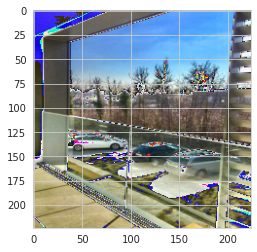

In [ ]:
#We check that the dataset class works well (note that as we apply normalization transform to the image, the output is a bit weird)
dataset_train=MyCustomDataset(data_trainset,PATH+IMAGE_FOLDER,transform=transformer)
sample=dataset_train[3]
print('Demand:', sample[2])
print('Tab Data', sample[1])
print('Id:',sample[3])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

Demand: tensor(19.)
Tab Data tensor([-0.5305, -0.0709,  0.3261,  1.3559, -0.8976, -0.1242,  0.5538,  0.5648,
        -0.0969,  0.5961, -0.5717, -0.0530, -0.1257, -0.1090, -0.0332,  0.4917,
        -0.3233, -1.6490, -2.1164, -2.1164,  0.6735, -0.3807, -0.9014, -1.3716,
        -0.0510, -1.3530, -1.6494, -0.1880, -0.8211, -1.6998, -0.5341, -0.5469,
        -0.9133, -0.4749])
Id: 7415.50.2130


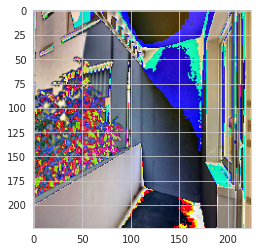

In [ ]:
#We check that the dataset class works well
dataset_val=MyCustomDataset(data_valset,PATH+IMAGE_FOLDER,transform=transformer)
sample=dataset_val[3]
print('Demand:', sample[2])
print('Tab Data', sample[1])
print('Id:',sample[3])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

Demand: tensor(nan)
Tab Data tensor([-5.3523e-01, -7.2991e-02, -1.3368e-01, -6.7655e-01,  5.6092e-01,
        -1.3345e-01,  5.5977e-01,  5.7655e-01, -1.0050e-01,  6.0181e-01,
        -5.5761e-01, -5.6656e-02, -1.3307e-01, -1.1205e-01, -2.8294e-02,
         1.1035e+00, -2.6177e-01, -8.9526e-01, -1.2251e+00, -1.2251e+00,
        -1.4911e+00, -1.3739e+00, -6.6744e-01, -1.4295e-01, -1.6142e-03,
        -7.1449e-02, -8.9589e-01, -1.9710e-01,  1.9828e+00,  1.3587e+00,
        -8.7171e-01, -9.4944e-01, -1.0168e+00, -6.2541e-01])
Id: 5898.06.5664


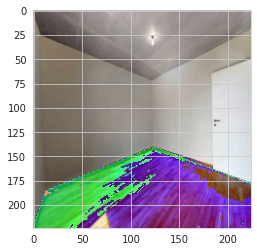

In [ ]:
#We check that the dataset class works well
dataset_pred=MyCustomDataset(data_pred_joined,PATH+IMAGE_FOLDER,transform=transformer)
sample=dataset_pred[3]
print('Demand:', sample[2])
print('Tab Data', sample[1])
print('Id:',sample[3])
plt.imshow(transforms.ToPILImage()(sample[0]))
plt.show()

In [ ]:
batch_size=64

#Defining batch loaders to run the model
train_loader=DataLoader(dataset=dataset_train,batch_size=batch_size,drop_last=True,shuffle=True,pin_memory=torch.cuda.is_available(),num_workers=10)
test_loader=DataLoader(dataset=dataset_val,batch_size=batch_size,pin_memory=torch.cuda.is_available(),num_workers=10)
pred_loader=DataLoader(dataset=dataset_pred,batch_size=batch_size,pin_memory=torch.cuda.is_available(),num_workers=10)

# Defining the model

In [ ]:
#CNN Network (for preprocessing the images)
class ConvNet(nn.Module):
  def __init__(self,img_size=img_size,dim_output=1):
    super(ConvNet,self).__init__()

    #Output size after convolution filter:
    #((width-kernel_size+2Padding)/stride)+1
    
    #Default Input shape (batch_size,num_channel,img_width,img_height)=(64,3,224,224)
    
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1,padding=2,bias=False)
    #Shape=(64,16,224,224)
    self.bn1=nn.BatchNorm2d(num_features=16)
    #Shape=(64,16,224,224)
    self.relu1=nn.ReLU()
    #Shape=(64,16,224,224)

    self.pool1=nn.MaxPool2d(kernel_size=2)
    #Reduce the image size by a factor 2
    #Shape=(64,16,112,112)

    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2,bias=False)
    #Shape=(64,32,112,112)
    self.bn2=nn.BatchNorm2d(num_features=32)
    #Shape=(64,32,112,112)
    self.relu2=nn.ReLU()
    #Shape=(64,32,112,112)

    self.pool2=nn.MaxPool2d(kernel_size=2)
    #Shape=(64,32,56,56)

    self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2,bias=False)
    #Shape=(64,64,56,56)
    self.bn3=nn.BatchNorm2d(num_features=64)
    #Shape=(64,64,56,56)
    self.relu3=nn.ReLU()
    #Shape=(64,64,56,56)

    self.pool3=nn.MaxPool2d(kernel_size=2)
    #Shape=(64,64,28,28)
    
    self.fc1=nn.Linear(in_features=64*28*28,out_features=16)
    self.bn4=nn.BatchNorm1d(num_features=16)
    self.dropout1=torch.nn.Dropout()

    #Genrates an output in R4
    self.fc2=nn.Linear(in_features=16,out_features=4)



  #Feed forward function:

  def forward(self,input):
    output=self.conv1(input)
    output=self.bn1(output)
    output=self.relu1(output)

    output=self.pool1(output)

    output=self.conv2(output)
    output=self.bn2(output)
    output=self.relu2(output)
    output=self.pool2(output)

    output=self.conv3(output)
    output=self.bn3(output)
    output=self.relu3(output)

    output=self.pool3(output)

    #Above output will be in matrix form with shape (64,64,28,28),  we flatten it

    output=output.view(-1,64*28*28)
    output=self.fc1(output)
    output=self.bn4(output)

    output=self.dropout1(output)

    output=self.fc2(output)


    return output



In [ ]:
#Connection model for tabular data
class TabDense(nn.Module):
  def __init__(self,tab_size=len_tab_features):
    super(TabDense,self).__init__()
    
    self.fc1=nn.Linear(in_features=tab_size,out_features=64)
    self.bn1=nn.BatchNorm1d(num_features=64)
    self.relu1=nn.ReLU()
    
    self.fc2=nn.Linear(in_features=64,out_features=128)
    self.relu2=nn.ReLU()
    
    self.fc3=nn.Linear(in_features=128,out_features=64)
    self.relu3=nn.ReLU()
   
    self.fc4=nn.Linear(in_features=64,out_features=32)
    self.relu4=nn.ReLU()
    self.fc5=nn.Linear(in_features=32,out_features=16)

    

  def forward(self,input):
    output=self.fc1(input)
    output=self.bn1(output)
    output=self.relu1(output)
    
    output=self.fc2(output)
    output=self.relu2(output)
    
    output=self.fc3(output)
    output=self.relu3(output)
    
    output=self.fc4(output)
    output=self.relu4(output)
    
    output=self.fc5(output)

    return output


In [ ]:
#Fully connected model to combine image vectorised (dim=4) and tabular data connected (dim=16)
class Combine(nn.Module):
  def __init__(self,img_vec_size=4,tab_size=16):
    super(Combine,self).__init__()
    self.fc1=nn.Linear(in_features=img_vec_size+tab_size,out_features=32)
    self.bn1=nn.BatchNorm1d(num_features=32)
    self.dropout1=torch.nn.Dropout()
    self.relu1=nn.ReLU()
    
    self.fc2=nn.Linear(in_features=32,out_features=64)
    self.relu2=nn.ReLU()

    self.fc3=nn.Linear(in_features=64,out_features=32)
    self.relu3=nn.ReLU()

    self.fc4=nn.Linear(in_features=32,out_features=16)
    self.relu4=nn.ReLU()

    self.fc5=nn.Linear(in_features=16,out_features=1)

    

  def forward(self,input):
    output=self.fc1(input)
    output=self.bn1(output)
    output=self.dropout1(output)
    outputs=self.relu1(output)
    
    output=self.fc2(output)
    output=self.relu2(output)

    output=self.fc3(output)
    output=self.relu3(output)

    output=self.fc4(output)
    output=self.relu4(output)

    output=self.fc5(output)

    return output


In [ ]:
#Function to compute mse and mdp on test set 
@torch.no_grad()
def validate_loss(img_model,tab_model,comb_model, device, val_loader, criterion):
    img_model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    tab_model.eval()
    comb_model.eval()
    test_loss = 0
    list_output=[]
    list_target=[]
    list_ids=[]
    for img, tab,target, id in val_loader:
        img,tab, target = img.to(device), tab.to(device),target.to(device)

        imag_vec=img_model(img)
        tab_dense=tab_model(tab)
        img_tab_concat=torch.cat([imag_vec,tab_dense],dim=1)
        output=comb_model(img_tab_concat)
        
        list_output.append(output)
        list_target.append(target)
        list_ids.append(id)
        test_loss += criterion(output, target.view_as(output)).item() * len(data)
   
    test_loss /= len(val_loader.dataset)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    outputs_values[np.where(outputs_values<=0)]=10**(-10)
    targets=[item for sublist in list_target for item in sublist]
    targets_values=np.array([x.item() for x in targets])
    id_values=np.array([item for sublist in list_ids for item in sublist])
    
    MPD=custom_poisson_deviance(targets_values,outputs_values)
    Mse=MSE(targets_values,outputs_values)
    #print('Test set: Mean Poisson Deviance: ',MPD,'MSE: ',Mse)

    return MPD,Mse


# Model Training

Epoch 0 Batch 0 Train MSE 4.183793067932129 Test MSE 92.98639455686619 Test MPD 234.06672033444417
Epoch 0 Batch 100 Train MSE 32.946754455566406 Test MSE 57.25568093758257 Test MPD 6.506340157808572
Epoch 0 Batch 200 Train MSE 31.42780113220215 Test MSE 50.694963340118655 Test MPD 5.540188331505865
Epoch 0 Batch 300 Train MSE 47.93507766723633 Test MSE 47.30296199560106 Test MPD 5.349197361155201
Epoch 0 Batch 400 Train MSE 31.73461151123047 Test MSE 46.56107249542505 Test MPD 5.029539326554523
Epoch 0 Batch 500 Train MSE 16.601909637451172 Test MSE 47.12191824791033 Test MPD 5.045684546262231
Epoch 1 Batch 0 Train MSE 65.58518981933594 Test MSE 49.621989887814074 Test MPD 5.6196800951501364
Epoch 1 Batch 100 Train MSE 41.00178527832031 Test MSE 47.821615738516506 Test MPD 4.820248824374417
Epoch 1 Batch 200 Train MSE 11.446426391601562 Test MSE 47.75775258758608 Test MPD 4.862898098149595
Epoch 1 Batch 300 Train MSE 7.665983200073242 Test MSE 51.27806485181786 Test MPD 4.748564361355

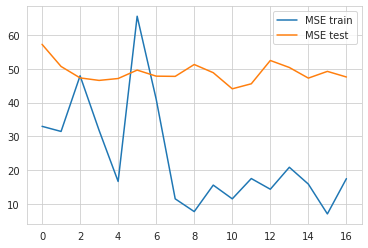

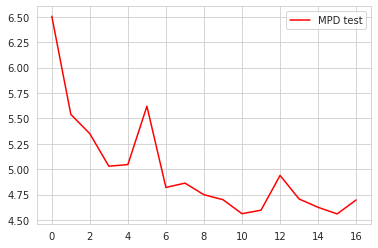

In [ ]:
CNN=ConvNet(img_size).to(device)
model_tab=TabDense().to(device)
model_combine=Combine().to(device)
loss_function=torch.nn.MSELoss()

#Optimizer and loss function
optimizer=Adam(chain(CNN.parameters(), model_tab.parameters(),model_combine.parameters()),lr=0.001,weight_decay=0.0001)

num_epochs=3
mse_history_train=[]
mse_history_test=[]
mpd_history_test=[]
for epoch in range(num_epochs):
  CNN.train()
  model_combine.train()
  model_tab.train()
  
  for i, (images,tabs,labels,ids) in enumerate(train_loader):
    #Every once in a while we check the performance on the validation set
    if i %100==0:
      mse_history_train.append(loss.item())
      MPD,Mse=validate_loss(CNN,model_tab,model_combine,device,test_loader,loss_function)
      print('Epoch',epoch,'Batch',i,'Train MSE',loss.item()
      ,'Test MSE',Mse,'Test MPD',MPD
      )
      mse_history_test.append(Mse)
      mpd_history_test.append(MPD)
    
    #Using GPU if available
    if torch.cuda.is_available():
      images=Variable(images.to(device))
      tabs=Variable(tabs.to(device))
      labels=Variable(labels.to(device))
  
    #Zeroing the gradient before each iteration
    for param in CNN.parameters():
      param.grad = None
    
    for param in model_tab.parameters():
      param.grad = None

    for param in model_combine.parameters():
      param.grad = None

    #Getting the vectorised images (R4)
    imag_vec=CNN(images)

    #Getting the connected tabular data (R16)
    tabs_dense=model_tab(tabs)

    #Concatenating them
    img_tab_concat=torch.cat([imag_vec,tabs_dense],dim=1)

    #Using our Combine model on them
    output=model_combine(img_tab_concat)

    #Computing loss
    loss=loss_function(output,labels.view_as(output))

    #And optimizing:
    loss.backward()
    optimizer.step()
      

plt.plot(mse_history_train[1:],label='MSE train')
plt.plot(mse_history_test[1:],label='MSE test')
plt.legend()
plt.show()
plt.plot(mpd_history_test[1:],label='MPD test',color='red')
plt.legend()
plt.show()

    

In [ ]:
#torch.save(CNN, PATH+'img_model.pkl')
#torch.save(model_tab, PATH+'tab_model.pkl')
#torch.save(model_combine, PATH+'combine_model.pkl')

# Evaluating the model

In [ ]:
#Function to go through the wholde dataset with the model trained and see what they output
@torch.no_grad()
def validate(img_model,tab_model,comb_model, device, val_loader, criterion):
    img_model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    tab_model.eval()
    comb_model.eval()
    test_loss = 0
    list_output=[]
    list_target=[]
    list_ids=[]
    for img, tab,target, id in val_loader:
        img,tab, target = img.to(device), tab.to(device),target.to(device)

        imag_vec=img_model(img)
        tab_dense=tab_model(tab)
        img_tab_concat=torch.cat([imag_vec,tab_dense],dim=1)
        output=comb_model(img_tab_concat)

        list_output.append(output)
        list_target.append(target)
        list_ids.append(id)
        test_loss += criterion(output, target.view_as(output)).item() * len(data)
   
    test_loss /= len(val_loader.dataset)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    outputs_values[np.where(outputs_values<=0)]=10**(-10)
    targets=[item for sublist in list_target for item in sublist]
    targets_values=np.array([x.item() for x in targets])
    id_values=np.array([item for sublist in list_ids for item in sublist])
    
    print('Mean Poisson Deviance: ',custom_poisson_deviance(targets_values,outputs_values),'MSE: ',
    MSE(targets_values,outputs_values))

    return outputs_values,targets_values, id_values 


In [ ]:
#Whenever we want to save the model
#torch.save(model, PATH+'model2.pkl')

In [ ]:
#Checking results on test set
outputs, targets,ids =validate(CNN,model_tab,model_combine,device,val_loader=test_loader,criterion=loss_function)
temp_df=pd.DataFrame(np.array([ids,outputs,targets]).T,columns=['Property Reference Id','Predictions','Target'])
display(temp_df)

In [ ]:
temp_df['Predictions']=temp_df['Predictions'].astype('float')
temp_df['Target']=temp_df['Target'].astype('float')
display(temp_df.describe())

#Averaging on the property ids
agg_df=temp_df.groupby('Property Reference Id').mean()
display(agg_df)
print('MPD on aggregated df',custom_poisson_deviance(agg_df['Target'].to_numpy(),agg_df['Predictions'].to_numpy()))

In [ ]:
agg_df=agg_df['Predictions'].reset_index()

In [ ]:
submission_df=data[data['Property Reference Id'].isin(ids_val)].merge(agg_df,on='Property Reference Id',how='left')

In [ ]:
print('MPD on aggregated df',custom_poisson_deviance(submission_df['Demand'].to_numpy(),submission_df['Predictions'].to_numpy()))

MPD on aggregated df 4.758355628876317


In [ ]:
#Checking if the predictions is not too concentrated around the mean
threshold=1
print('There are ',len(temp_df[temp_df['Predictions'].astype('float32')>threshold]),'out of ',len(temp_df), 'predictions greater than ',threshold)

There are  20396 out of  32640 predictions greater than  1


# Submitting prediction

In [ ]:
#Loading the trained model if saved previously
img_model=torch.load(PATH+'img_model.pkl')
tab_model=torch.load(PATH+'tab_model.pkl')
combine_model=torch.load(PATH+'combine_model.pkl')

In [ ]:
#Function to build the prediction from the pred_loader (which has nan as output for the demand variable)
@torch.no_grad()
def pred_output(img_model,tab_model,comb_model, device, test_loader,):
    img_model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    tab_model.eval()
    comb_model.eval()
    list_output=[]
    list_ids=[]
    for img, tab,target, id in test_loader:
        img,tab, target = img.to(device), tab.to(device),target.to(device)

        imag_vec=img_model(img)
        tab_dense=tab_model(tab)
        img_tab_concat=torch.cat([imag_vec,tab_dense],dim=1)
        output=comb_model(img_tab_concat)

        list_output.append(output)
        list_ids.append(id)

    outputs=[item for sublist in list_output for item in sublist]
    outputs_values=np.array([x.item() for x in outputs])
    outputs_values[np.where(outputs_values<=0)]=10**(-10)
    id_values=np.array([item for sublist in list_ids for item in sublist])
    
    return outputs_values,id_values 


In [ ]:
outputs,ids =pred_output(img_model,tab_model,combine_model,device,test_loader=pred_loader)

In [ ]:
pred_df=pd.DataFrame(np.array([ids,outputs]).T,columns=['Property Reference Id','Prediction'])
pred_df['Prediction']=pred_df['Prediction'].astype('float')
display(pred_df)
display(pred_df.describe())
pred_df_agg=pred_df.groupby('Property Reference Id').mean().reset_index()

,Property Reference Id,Prediction
0,5898.06.5664,1.310973
1,5898.06.5664,1.360035
2,5898.06.5664,1.470561
3,5898.06.5664,1.371604
4,5898.06.5664,1.709277
...,...,...
29814,4839.61.9732,5.117579
29815,4839.61.9732,5.087009
29816,4839.61.9732,5.057633
29817,4839.61.9732,5.029871


,Prediction
count,29819.000000
mean,4.560199
std,5.370339
min,0.410161
25%,1.948129
50%,3.459882
75%,5.186934
max,96.350227


In [ ]:
#Merging with the listing_test_overall df provided for submission
submission_df=data_test_overall.drop('Prediction',axis=1).merge(pred_df_agg,on='Property Reference Id',how='left')

In [ ]:
#Saving the submissiom
submission_df.to_csv(PATH+'listing_prediction_tabular_image.csv',index=False)

In [ ]:
submission_df

,Are Pets Allowed,Category Idx,Day of Advertisement Created,Day of Date Available From,Floor,Geo Canton,Geo City,Geo Zip,Has Balcony,Has Cabletv,...,Price Extra Normalized,Price Gross Normalized,Price M2 Normalized,Price Net Normalized,Property Reference Id,Size M2 Normalized,Subcategory En Idx,Year Built,Year Lastrenovated,Prediction
0,True,APPT,"June 18, 2019","September 1, 2019",1.0,AG,Obersiggenthal,5415,NaN,True,...,79.0,949.0,26.0,870.0,8469.26.3115,36.0,Apartment,NaN,NaN,NaN
1,True,APPT,"January 5, 2021","April 1, 2021",1.0,SO,Obergösgen,4653,NaN,True,...,170.0,1120.0,18.0,950.0,5923.03.2935,63.0,Apartment,1965.0,2010.0,NaN
2,NaN,APPT,"January 12, 2021","April 1, 2021",2.0,VD,Renens VD,1020,NaN,NaN,...,180.0,1730.0,32.0,1550.0,5898.06.5664,54.0,Apartment,2017.0,2017.0,1.493731
3,False,APPT,"February 3, 2017","March 1, 2017",8.0,GE,Chêne-Bougeries,1224,False,True,...,70.0,1070.0,33.0,1000.0,6321.61.6570,32.0,Attic flat,NaN,NaN,NaN
4,True,APPT,"August 5, 2019","September 1, 2019",3.0,VD,Lausanne,1018,NaN,True,...,335.0,1915.0,22.0,1580.0,3036.61.1151,86.0,Apartment,NaN,NaN,5.304990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,APPT,"June 21, 2017","August 1, 2017",7.0,FR,Fribourg,1700,False,True,...,300.0,1790.0,20.0,1490.0,3743.61.8724,88.0,Apartment,NaN,NaN,NaN
9996,NaN,HOUSE,"April 10, 2019","July 1, 2019",0.0,ZH,Uster,8610,NaN,NaN,...,290.0,2880.0,25.0,2590.0,2783.47.3282,115.0,Row house,NaN,NaN,NaN
9997,NaN,APPT,"November 8, 2021","February 1, 2022",3.0,ZH,Thalwil,8800,NaN,NaN,...,300.0,2600.0,29.0,2300.0,9988.68.0891,91.0,Apartment,1974.0,2008.0,NaN
9998,NaN,APPT,"May 12, 2021","July 1, 2021",4.0,ZH,Wallisellen,8304,NaN,NaN,...,NaN,NaN,NaN,NaN,8929.92.2004,41.0,Apartment,NaN,NaN,NaN
